In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.mixture import GaussianMixture
from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from kneed import KneeLocator

In [2]:
import pandas as pd

# ==== 0) Parâmetros ====
ARQ_IN    = "Matrix.csv"        # saída do passo anterior (pivot pronto)
OUT_W     = "W_frames.csv"      # pesos por frame (frames × K)
OUT_H     = "H_padroes.csv"     # padrões (K × células)
OUT_TOP   = "frames_tipicos_CNN_KMEANS.csv"
SEED      = 42
MAX_ITER  = 2000

# Ler a matriz W gerada pelo NMF (output do passo anterior)
df_W = pd.read_csv("nmf_W_TS.csv", index_col=0)

X = df_W.values   # <--- garantir que W está em df_W
print("Shape da matriz W:", X.shape)
df_W.head()   # <--- garantir que W está em df_W




Shape da matriz W: (850, 16)


,padrao_1,padrao_2,padrao_3,padrao_4,padrao_5,padrao_6,padrao_7,padrao_8,padrao_9,padrao_10,padrao_11,padrao_12,padrao_13,padrao_14,padrao_15,padrao_16
timestamp,,,,,,,,,,,,,,,,
1900-01-01 00:00:00.852,0.000000,0.000000e+00,9.431295e-155,4.226021e-83,1.195915e-46,0.000000,4.593524e-101,4.508182e-78,2.806507e-59,1.863434e+00,1.012762e+00,1.009208e-81,1.281967e-36,3.629010e-117,1.750227e-20,0.00000
1900-01-01 00:00:03.401,0.262673,0.000000e+00,5.756467e-252,1.953594e-82,5.694325e-19,0.599497,2.788895e-51,2.802952e-20,3.734614e-61,1.502444e-220,5.382139e-69,0.000000e+00,2.958861e-01,2.446862e-78,1.687845e+00,0.00000
1900-01-01 00:00:07.974,0.000000,0.000000e+00,1.308255e+00,0.000000e+00,1.138317e-271,0.000000,4.752867e-57,3.591706e-76,0.000000e+00,2.669327e-01,4.382321e-115,0.000000e+00,1.575743e-82,1.414540e-143,0.000000e+00,0.00000
1900-01-01 00:00:08.614,0.000000,1.649873e-47,0.000000e+00,6.107327e-01,0.000000e+00,0.002216,0.000000e+00,1.455044e-79,2.497476e-01,0.000000e+00,0.000000e+00,4.036409e-01,2.688885e-23,2.562473e-01,0.000000e+00,0.74553
1900-01-01 00:00:09.458,0.000000,0.000000e+00,1.468883e+00,6.498513e-184,9.167106e-90,0.000000,1.319310e-48,0.000000e+00,0.000000e+00,5.520660e-58,0.000000e+00,1.458454e-129,0.000000e+00,0.000000e+00,3.110900e-14,0.00000


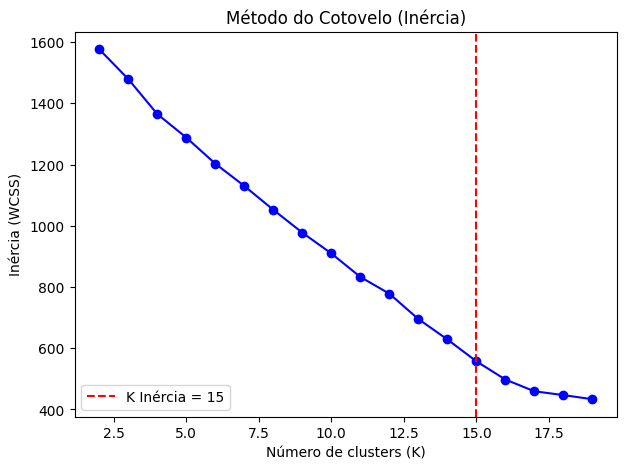

➡️ K escolhido pelo Método do Cotovelo: 15


In [3]:
# ==============================================
# Método do Cotovelo (Inércia) + Kneed
# ==============================================

#from kneed import KneeLocator

# Intervalo de K
Ks = range(2, 20)
inertias = []

# Calcular inércia para cada K
for k in Ks:
    km = KMeans(n_clusters=k, random_state=SEED, n_init=10)
    km.fit(X)
    inertias.append(km.inertia_)

inertias = np.array(inertias)

# Encontrar "cotovelo" automaticamente
kl = KneeLocator(list(Ks), inertias, curve="convex", direction="decreasing")
k_inercia = kl.knee

# Plot
plt.figure(figsize=(7,5))
plt.plot(Ks, inertias, marker="o", color="blue")
if k_inercia is not None:
    plt.axvline(k_inercia, color="red", linestyle="--", label=f"K Inércia = {k_inercia}")
plt.xlabel("Número de clusters (K)")
plt.ylabel("Inércia (WCSS)")
plt.title("Método do Cotovelo (Inércia)")
plt.legend()
plt.grid(False)
plt.show()

print(f"➡️ K escolhido pelo Método do Cotovelo: {k_inercia}")



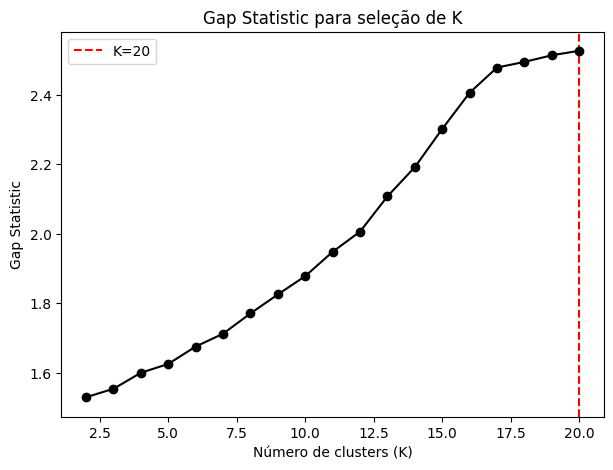

In [4]:
# ==============================================
# Gap Statistic 
# ==============================================

# Função para calcular dispersão intra-cluster
def compute_dispersion(X, labels, centers):
    return np.sum([np.sum((X[labels == i] - centers[i])**2) for i in range(len(centers))])

# Função principal do Gap Statistic
def gap_statistic(X, n_refs=50, max_k=20, random_state=SEED):
    np.random.seed(random_state)
    results = []
    for k in range(2, max_k+1):
        # Clustering real
        km = KMeans(n_clusters=k, random_state=random_state, n_init=10)
        labels = km.fit_predict(X)
        disp_real = compute_dispersion(X, labels, km.cluster_centers_)

        # Clustering em dados de referência aleatórios
        ref_disps = []
        for i in range(n_refs):
            X_ref = np.random.uniform(low=np.min(X, axis=0), high=np.max(X, axis=0), size=X.shape)
            km_ref = KMeans(n_clusters=k, random_state=random_state+i, n_init=5)
            labels_ref = km_ref.fit_predict(X_ref)
            ref_disps.append(compute_dispersion(X_ref, labels_ref, km_ref.cluster_centers_))

        # Gap
        log_disp_ref = np.log(ref_disps)
        gap = np.mean(log_disp_ref) - np.log(disp_real)
        sdk = np.sqrt(1 + 1/n_refs) * np.std(log_disp_ref)
        results.append({"k": k, "gap": gap, "s_k": sdk})

    return pd.DataFrame(results)

# Calcular gap statistic
df_gap = gap_statistic(X, n_refs=10, max_k=20)

# Determinar K pelo critério do Gap
for i in range(len(df_gap)-1):
    if df_gap.loc[i, "gap"] >= df_gap.loc[i+1, "gap"] - df_gap.loc[i+1, "s_k"]:
        k_gap = int(df_gap.loc[i, "k"])
        break
else:
    k_gap = int(df_gap.loc[df_gap["gap"].idxmax(), "k"])

# Plot
plt.figure(figsize=(7,5))
plt.errorbar(df_gap["k"], df_gap["gap"], yerr=df_gap["s_k"], fmt='-o', color="black")
plt.axvline(k_gap, color="red", linestyle="--", label=f"K={k_gap}")
plt.xlabel("Número de clusters (K)")
plt.ylabel("Gap Statistic")
plt.title("Gap Statistic para seleção de K")
plt.legend()
plt.grid(False)
plt.show()


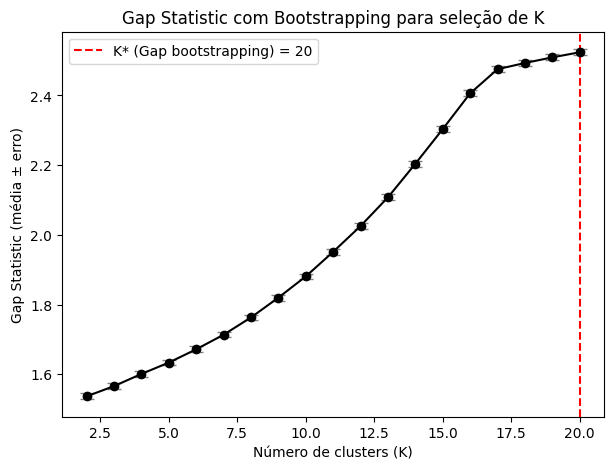

➡️ K escolhido pelo Gap Statistic com bootstrapping: 20


In [5]:
# ==============================================
# Gap Statistic com Bootstrapping (média de vários runs)
# ==============================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# ---- Função para calcular dispersão intra-cluster ----
def compute_dispersion(X, labels, centers):
    return np.sum([np.sum((X[labels == i] - centers[i])**2) for i in range(len(centers))])

# ---- Gap Statistic para 1 execução ----
def gap_statistic_single(X, n_refs=20, max_k=20, random_state=42):
    np.random.seed(random_state)
    results = []
    ref_disps = np.zeros((n_refs, max_k-1))

    for k in range(2, max_k+1):
        # Clustering nos dados reais
        km = KMeans(n_clusters=k, random_state=random_state, n_init=10)
        labels = km.fit_predict(X)
        disp = compute_dispersion(X, labels, km.cluster_centers_)

        # Clustering em dados de referência
        for i in range(n_refs):
            X_ref = np.random.uniform(low=np.min(X, axis=0),
                                      high=np.max(X, axis=0),
                                      size=X.shape)
            km_ref = KMeans(n_clusters=k, random_state=random_state+i, n_init=5)
            labels_ref = km_ref.fit_predict(X_ref)
            ref_disps[i, k-2] = compute_dispersion(X_ref, labels_ref, km_ref.cluster_centers_)

        # Gap
        log_disp_ref = np.log(ref_disps[:, k-2])
        gap = np.mean(log_disp_ref) - np.log(disp)
        sdk = np.sqrt(1 + 1/n_refs) * np.std(log_disp_ref)

        results.append({"k": k, "gap": gap, "s_k": sdk})

    return pd.DataFrame(results)

# ---- Gap Statistic com Bootstrapping ----
def gap_statistic_bootstrap(X, n_runs=10, n_refs=20, max_k=20, random_state=42):
    all_runs = []
    for run in range(n_runs):
        df_run = gap_statistic_single(X, n_refs=n_refs, max_k=max_k, random_state=random_state+run)
        df_run["run"] = run
        all_runs.append(df_run)
    df_all = pd.concat(all_runs)

    # Média e desvio do Gap por K
    df_summary = df_all.groupby("k").agg({"gap":"mean", "s_k":"mean"}).reset_index()
    return df_summary

# ---- Calcular Gap Statistic com bootstrapping ----
df_gap_boot = gap_statistic_bootstrap(X, n_runs=20, n_refs=20, max_k=20, random_state=SEED)

# ---- Selecionar K ótimo pelo critério de Tibshirani ----
k_gap_boot = None
for i in range(len(df_gap_boot)-1):
    if df_gap_boot.loc[i, "gap"] >= df_gap_boot.loc[i+1, "gap"] - df_gap_boot.loc[i+1, "s_k"]:
        k_gap_boot = int(df_gap_boot.loc[i, "k"])
        break
if k_gap_boot is None:
    k_gap_boot = int(df_gap_boot.loc[df_gap_boot["gap"].idxmax(), "k"])

# ---- Plot ----
plt.figure(figsize=(7,5))
plt.errorbar(df_gap_boot["k"], df_gap_boot["gap"],
             yerr=df_gap_boot["s_k"],
             fmt='-o', color="black", ecolor="gray", capsize=5)
plt.axvline(k_gap_boot, color="red", linestyle="--", label=f"K* (Gap bootstrapping) = {k_gap_boot}")
plt.xlabel("Número de clusters (K)")
plt.ylabel("Gap Statistic (média ± erro)")
plt.title("Gap Statistic com Bootstrapping para seleção de K")
plt.legend()
plt.grid(False)
plt.show()

print(f"➡️ K escolhido pelo Gap Statistic com bootstrapping: {k_gap_boot}")


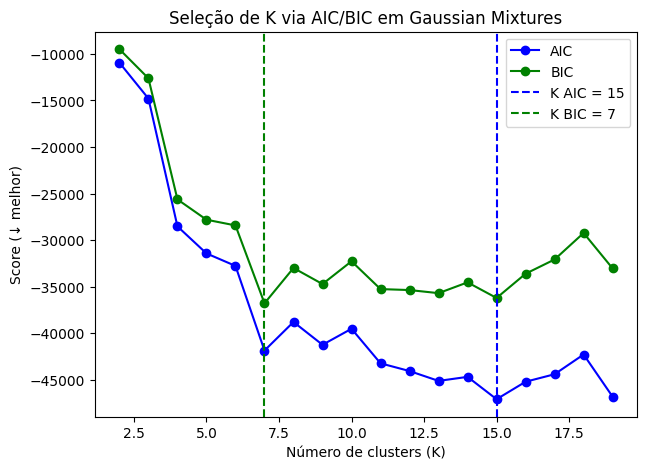

➡️ K escolhido pelo AIC: 15
➡️ K escolhido pelo BIC: 7


,AIC,ΔAIC,BIC,ΔBIC
K,,,,
2,-10935.825918,36180.597179,-9488.528831,27316.103969
3,-14793.753814,32322.669282,-12620.435566,24184.197234
4,-28536.454407,18579.968690,-25637.114997,11167.517803
5,-31441.901640,15674.521456,-27816.541069,8988.091731
6,-32784.360091,14332.063005,-28432.978359,8371.654442
7,-41882.035694,5234.387402,-36804.632800,0.000000
8,-38811.410476,8305.012620,-33007.986421,3796.646379
9,-41264.011644,5852.411452,-34734.566427,2070.066373
10,-39541.419076,7575.004021,-32285.952697,4518.680103


In [6]:
# ==============================================
# Seleção automática de K via AIC / BIC +  + ΔAIC/ΔBIC
# ==============================================

from sklearn.mixture import GaussianMixture

Ks = range(2, 20)
aic_vals, bic_vals = [], []

for k in Ks:
    gmm = GaussianMixture(n_components=k, random_state=SEED)
    gmm.fit(X)
    aic_vals.append(gmm.aic(X))
    bic_vals.append(gmm.bic(X))

aic_vals = np.array(aic_vals)
bic_vals = np.array(bic_vals)

# Melhor K
k_aic = Ks[np.argmin(aic_vals)]
k_bic = Ks[np.argmin(bic_vals)]

# ΔAIC / ΔBIC
delta_aic = aic_vals - np.min(aic_vals)
delta_bic = bic_vals - np.min(bic_vals)

# Plot
plt.figure(figsize=(7,5))
plt.plot(Ks, aic_vals, marker="o", label="AIC", color="blue")
plt.plot(Ks, bic_vals, marker="o", label="BIC", color="green")
plt.axvline(k_aic, color="blue", linestyle="--", label=f"K AIC = {k_aic}")
plt.axvline(k_bic, color="green", linestyle="--", label=f"K BIC = {k_bic}")
plt.xlabel("Número de clusters (K)")
plt.ylabel("Score (↓ melhor)")
plt.title("Seleção de K via AIC/BIC em Gaussian Mixtures")
plt.legend()
plt.grid(False)
plt.show()

# Resumo em tabela
df_aicbic = pd.DataFrame({
    "K": Ks,
    "AIC": aic_vals,
    "ΔAIC": delta_aic,
    "BIC": bic_vals,
    "ΔBIC": delta_bic
}).set_index("K")

print(f"➡️ K escolhido pelo AIC: {k_aic}")
print(f"➡️ K escolhido pelo BIC: {k_bic}")
df_aicbic


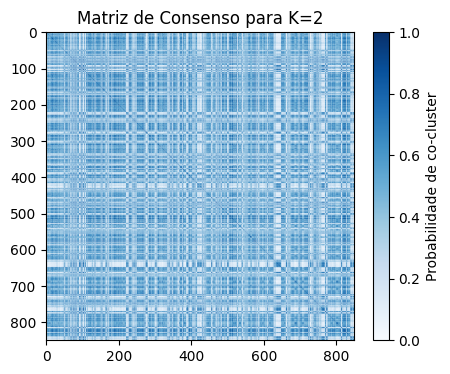

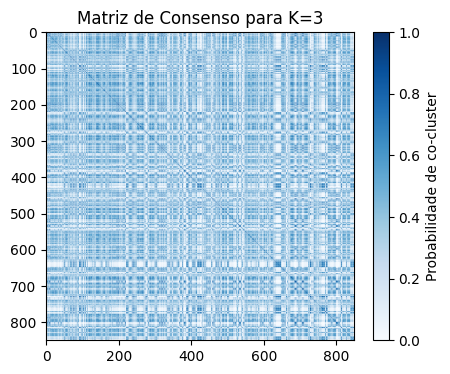

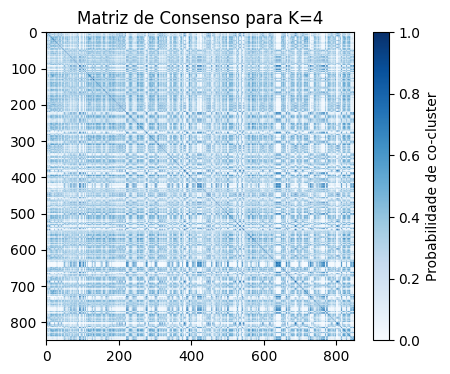

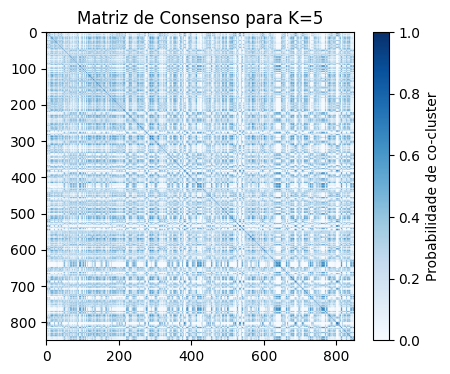

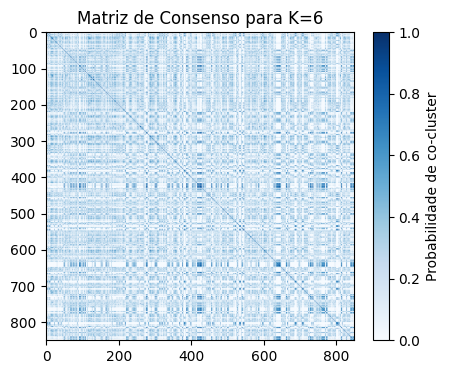

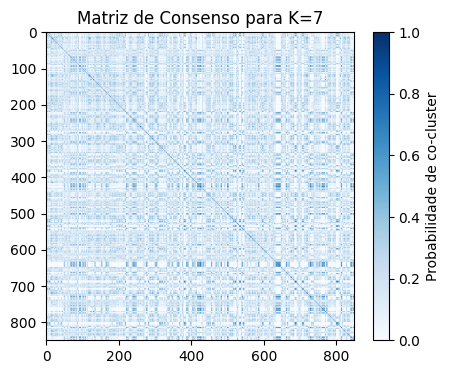

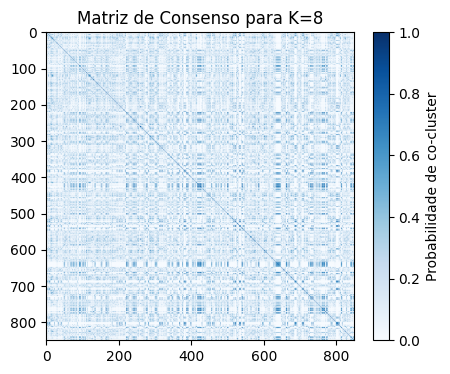

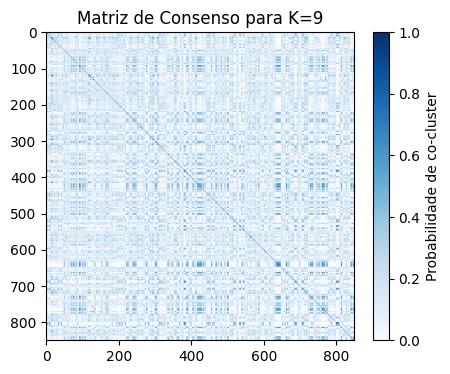

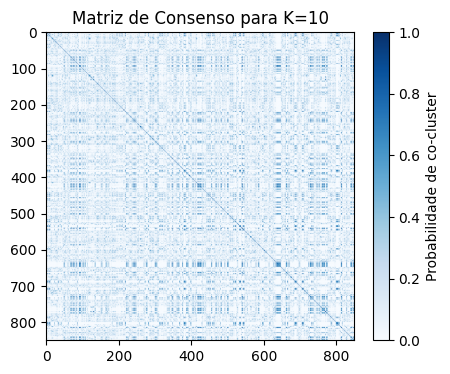

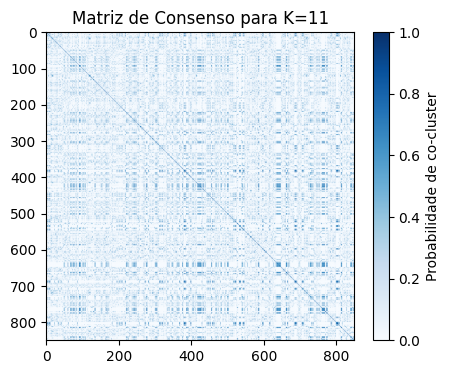

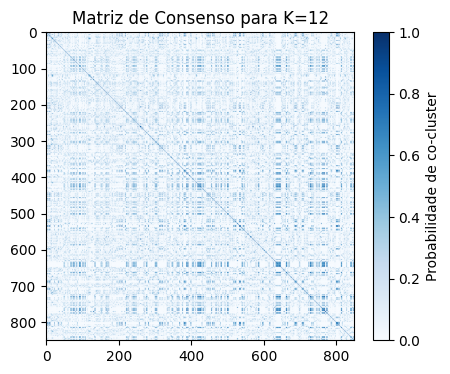

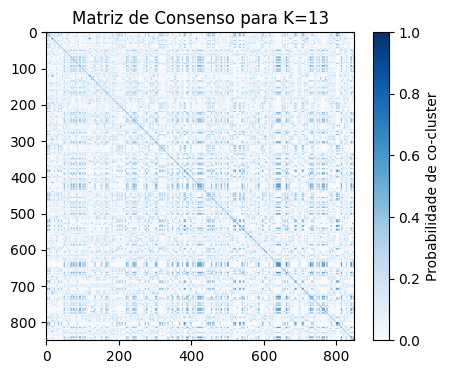

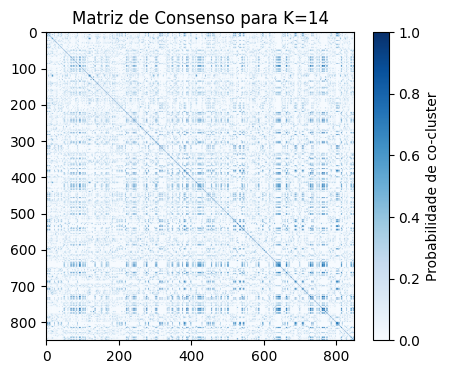

➡️ Scores de consenso (quanto maior, mais estável):
K=2: 0.268
K=3: 0.429
K=4: 0.547
K=5: 0.562
K=6: 0.608
K=7: 0.678
K=8: 0.746
K=9: 0.774
K=10: 0.825
K=11: 0.854
K=12: 0.865
K=13: 0.877
K=14: 0.886

➡️ K escolhido pelo Consensus Clustering: 14


In [7]:
# ==============================================
# Consensus Clustering com escolha automática de K + Índice Global de Consenso
# ==============================================
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt

# Função para construir matriz de consenso
def consensus_matrix(X, k, n_runs=20, frac=0.8):
    """
    Constrói matriz de consenso para K clusters.
    Cada célula [i,j] indica a proporção de vezes em que
    os pontos i e j foram colocados no mesmo cluster.
    """
    n = len(X)
    consensus = np.zeros((n, n))  # matriz de co-associação
    
    for run in range(n_runs):
        # Amostra de pontos (subsample sem reposição)
        idx = np.random.choice(n, int(frac*n), replace=False)
        X_sub = X[idx]
        
        # Clustering nesta amostra
        km = KMeans(n_clusters=k, random_state=SEED+run, n_init=10)
        labels = km.fit_predict(X_sub)
        
        # Atualizar matriz de consenso (pares no mesmo cluster)
        for i in range(len(idx)):
            for j in range(len(idx)):
                if labels[i] == labels[j]:
                    consensus[idx[i], idx[j]] += 1
    
    # Normalizar [0,1]
    consensus = consensus / n_runs
    return consensus

# Função para calcular score de estabilidade de uma matriz de consenso
def consensus_score(C, threshold=0.8):
    """
    Mede a estabilidade de uma matriz de consenso.
    Score = proporção de entradas próximas de 0 ou 1.
    """
    flat = C.flatten()
    near_extremes = np.mean((flat < 1-threshold) | (flat > threshold))
    return near_extremes

# Definir intervalo de K a testar
Ks = range(2, 15)  # ajusta conforme necessário

# Calcular matrizes e scores de consenso
consensus_results = {}
scores_consensus = {}

for k in Ks:
    C = consensus_matrix(X, k)
    consensus_results[k] = C
    scores_consensus[k] = consensus_score(C)
    
    # Plot heatmap
    plt.figure(figsize=(5,4))
    plt.imshow(C, cmap="Blues")
    plt.colorbar(label="Probabilidade de co-cluster")
    plt.title(f"Matriz de Consenso para K={k}")
    plt.grid(False)
    plt.show()

# Selecionar K com maior score de consenso
k_consensus = max(scores_consensus, key=scores_consensus.get)

print("➡️ Scores de consenso (quanto maior, mais estável):")
for k, score in scores_consensus.items():
    print(f"K={k}: {score:.3f}")

print(f"\n➡️ K escolhido pelo Consensus Clustering: {k_consensus}")


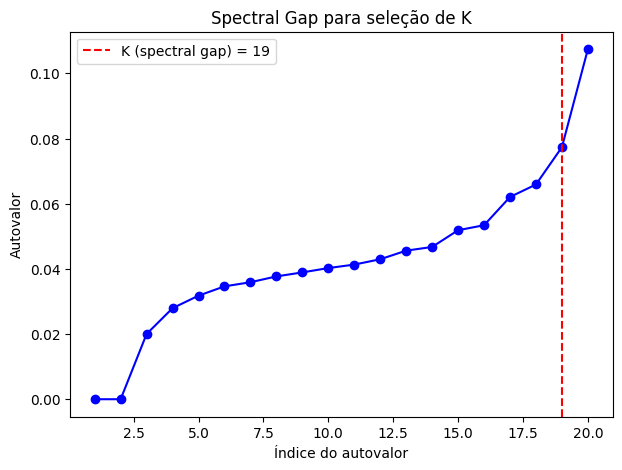

In [8]:
# ==============================================
# Spectral Gap (em clustering espectral)
# ==============================================
from sklearn.neighbors import kneighbors_graph
from scipy.sparse.linalg import eigsh

# Construir grafo de similaridade (k-vizinhos mais próximos)
A = kneighbors_graph(X, n_neighbors=10, include_self=False)
A = 0.5 * (A + A.T)  # simetrizar

# Calcular Laplaciano normalizado
D = np.array(A.sum(axis=1)).flatten()
D_inv_sqrt = np.diag(1.0 / np.sqrt(D + 1e-10))
L = np.eye(len(D)) - D_inv_sqrt @ A.toarray() @ D_inv_sqrt

# Calcular autovalores
vals, vecs = eigsh(L, k=20, which="SM")  # 20 menores autovalores

# Spectral gap = maior salto entre autovalores consecutivos
gaps = np.diff(vals)
best_k = np.argmax(gaps) + 1  # +1 porque indexing começa no 0

# Plot
plt.figure(figsize=(7,5))
plt.plot(range(1, len(vals)+1), vals, marker="o", color="blue")
plt.axvline(best_k, color="red", linestyle="--", label=f"K (spectral gap) = {best_k}")
plt.xlabel("Índice do autovalor")
plt.ylabel("Autovalor")
plt.title("Spectral Gap para seleção de K")
plt.legend()
plt.grid(False)
plt.show()


In [9]:
# ==============================================
# Estabilidade por ARI e NMI (resampling bootstrap)
# aplicada aos K sugeridos por outros métodos
# ==============================================
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.utils import resample

# Função para calcular estabilidade
def cluster_stability(X, k, n_boots=10, frac=0.8):
    ari_scores, nmi_scores = [], []
    
    # Clustering base no dataset completo
    km = KMeans(n_clusters=k, random_state=SEED, n_init=10)
    labels_full = km.fit_predict(X)

    # Reamostragem bootstrap
    for i in range(n_boots):
        X_boot, _ = resample(X, labels_full, replace=True, n_samples=int(frac*len(X)))
        km_boot = KMeans(n_clusters=k, random_state=SEED+i, n_init=5)
        labels_boot = km_boot.fit_predict(X_boot)

        # Comparar atribuições com o clustering de referência
        ari_scores.append(adjusted_rand_score(labels_full[:len(X_boot)], labels_boot))
        nmi_scores.append(normalized_mutual_info_score(labels_full[:len(X_boot)], labels_boot))

    # Devolver médias e desvios
    return np.mean(ari_scores), np.std(ari_scores), np.mean(nmi_scores), np.std(nmi_scores)

# ==============================
# Recolher os K dos métodos anteriores
# ==============================
Ks_test = list(set([
    k_inercia,     # Elbow
    k_gap,         # Gap Statistic
    k_aic,         # AIC
    k_bic,         # BIC
    k_consensus,   # Consensus Clustering
    # best_k_spectral  # se já tiveres calculado o Spectral Gap
]))

print("➡️ Ks a testar na estabilidade:", Ks_test)

# ==============================
# Calcular estabilidade para esses K
# ==============================
results = []
for k in Ks_test:
    ari_m, ari_s, nmi_m, nmi_s = cluster_stability(X, k)
    results.append({
        "k": k,
        "ARI_mean": ari_m, "ARI_std": ari_s,
        "NMI_mean": nmi_m, "NMI_std": nmi_s
    })

# DataFrame final
df_stability = pd.DataFrame(results).sort_values("k").reset_index(drop=True)
df_stability


➡️ Ks a testar na estabilidade: [20, 7, 14, np.int64(15)]


,k,ARI_mean,ARI_std,NMI_mean,NMI_std
0,7,0.000600,0.006138,0.016951,0.003605
1,14,-0.000411,0.004188,0.058032,0.005612
2,15,0.000199,0.004540,0.066519,0.005573
3,20,-0.002290,0.003053,0.102788,0.002746


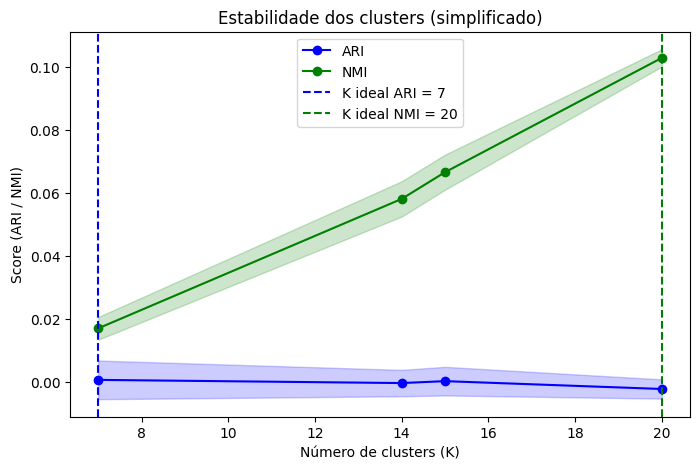

In [10]:
# ==============================================
# Plot da estabilidade (ARI / NMI) para Ks sugeridos
# ==============================================
import matplotlib.pyplot as plt
import numpy as np

Ks = df_stability["k"].values
ARI_means = df_stability["ARI_mean"].values
ARI_stds  = df_stability["ARI_std"].values
NMI_means = df_stability["NMI_mean"].values
NMI_stds  = df_stability["NMI_std"].values

width = 0.35  # largura das barras

# Identificar K ideais
k_ari = Ks[np.argmax(ARI_means)]
k_nmi = Ks[np.argmax(NMI_means)]

# ==============================================
# Gráfico simplificado da estabilidade (ARI / NMI)
# ==============================================
plt.figure(figsize=(8,5))

# ARI
plt.plot(df_stability["k"], df_stability["ARI_mean"], marker="o", color="blue", label="ARI")
plt.fill_between(df_stability["k"],
                 df_stability["ARI_mean"] - df_stability["ARI_std"],
                 df_stability["ARI_mean"] + df_stability["ARI_std"],
                 color="blue", alpha=0.2)

# NMI
plt.plot(df_stability["k"], df_stability["NMI_mean"], marker="o", color="green", label="NMI")
plt.fill_between(df_stability["k"],
                 df_stability["NMI_mean"] - df_stability["NMI_std"],
                 df_stability["NMI_mean"] + df_stability["NMI_std"],
                 color="green", alpha=0.2)

# Destacar Ks ótimos
k_ari = df_stability.loc[df_stability["ARI_mean"].idxmax(), "k"]
k_nmi = df_stability.loc[df_stability["NMI_mean"].idxmax(), "k"]

plt.axvline(k_ari, color="blue", linestyle="--", label=f"K ideal ARI = {k_ari}")
plt.axvline(k_nmi, color="green", linestyle="--", label=f"K ideal NMI = {k_nmi}")

# Configuração
plt.xlabel("Número de clusters (K)")
plt.ylabel("Score (ARI / NMI)")
plt.title("Estabilidade dos clusters (simplificado)")
plt.legend()
plt.grid(False)
plt.show()


In [11]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Avaliar apenas os Ks candidatos
results_quality = []
for k in Ks_test:  # Ks_test = [k_inercia, k_gap, k_aic, ...]
    km = KMeans(n_clusters=k, random_state=SEED, n_init=10)
    labels = km.fit_predict(X)
    
    sil = silhouette_score(X, labels)
    db  = davies_bouldin_score(X, labels)
    ch  = calinski_harabasz_score(X, labels)
    
    results_quality.append({
        "k": k,
        "Silhouette": sil,
        "Davies-Bouldin": db,
        "Calinski-Harabasz": ch
    })

df_quality = pd.DataFrame(results_quality).sort_values("k")
df_quality


,k,Silhouette,Davies-Bouldin,Calinski-Harabasz
1,7,0.197158,1.726899,71.245602
2,14,0.331889,1.305335,109.838279
3,15,0.353238,1.218134,122.562923
0,20,0.336813,1.206167,131.968156


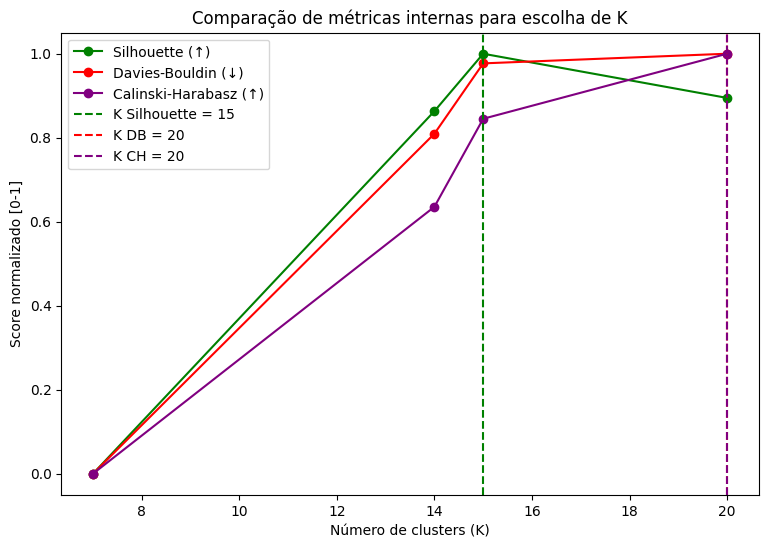

In [12]:
# ==============================================
# Gráfico comparativo: Silhouette, DB, CH
# ==============================================
from sklearn.preprocessing import MinMaxScaler

# Normalizar métricas para [0,1]
scaler = MinMaxScaler()
df_norm = df_quality.copy()
df_norm[["Silhouette_norm", "DB_norm", "CH_norm"]] = scaler.fit_transform(
    df_quality[["Silhouette", "Davies-Bouldin", "Calinski-Harabasz"]]
)

# Inverter DB (porque ↓ é melhor → queremos ↑)
df_norm["DB_norm"] = 1 - df_norm["DB_norm"]

plt.figure(figsize=(9,6))

plt.plot(df_norm["k"], df_norm["Silhouette_norm"], marker="o", label="Silhouette (↑)", color="green")
plt.plot(df_norm["k"], df_norm["DB_norm"], marker="o", label="Davies-Bouldin (↓)", color="red")
plt.plot(df_norm["k"], df_norm["CH_norm"], marker="o", label="Calinski-Harabasz (↑)", color="purple")

# Destacar melhor K segundo cada métrica
best_sil = df_norm.loc[df_norm["Silhouette"].idxmax(), "k"]
best_db  = df_norm.loc[df_norm["Davies-Bouldin"].idxmin(), "k"]
best_ch  = df_norm.loc[df_norm["Calinski-Harabasz"].idxmax(), "k"]

plt.axvline(best_sil, color="green", linestyle="--", label=f"K Silhouette = {best_sil}")
plt.axvline(best_db,  color="red", linestyle="--", label=f"K DB = {best_db}")
plt.axvline(best_ch,  color="purple", linestyle="--", label=f"K CH = {best_ch}")

plt.xlabel("Número de clusters (K)")
plt.ylabel("Score normalizado [0-1]")
plt.title("Comparação de métricas internas para escolha de K")
plt.legend()
plt.grid(False)
plt.show()
